In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
def plot_cwts(instances, images_per_row=10, **options):
    size = 100
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
    
# Code example
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model

from scipy.signal import butter, lfilter


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [4]:
time_data = pd.read_csv("C:\\Users\\mmang\\source\\repos\\MindGamesApi\\MindGamesApi\\Jupyter Notebooks\\datasets\\CWT_DATA_very_not_flat.csv", thousands=',')

In [13]:
time_data.head()

,Channel,10-20,ChannelGroup,Volts,TimeStamp
0,1,P4,0,-0.165205,4639
1,2,POz,0,-0.165960,4639
2,3,PO4,0,0.463611,4639
3,4,O2,0,0.467530,4639
4,5,O1,0,-0.202242,4639


In [19]:
channel_group_data = time_data.groupby(['ChannelGroup'])
channel_group_data.head()

,Channel,10-20,ChannelGroup,Volts,TimeStamp
0,1,P4,0,-0.165205,4639
1,2,POz,0,-0.165960,4639
2,3,PO4,0,0.463611,4639
3,4,O2,0,0.467530,4639
4,5,O1,0,-0.202242,4639
...,...,...,...,...,...
24408,1,P4,3051,0.108091,15900
24409,2,POz,3051,0.887907,15900
24410,3,PO4,3051,0.724070,15900
24411,4,O2,3051,-0.147856,15900


In [201]:
period_data = []

from scipy import signal
from itertools import zip_longest

def grouper(iterable, n, fillvalue=None):
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

period_data = grouper(channel_group_data, 100)
channels_grouped_100 = list(period_data)[:-1]

channels_grouped_100[0][0]

(0,
    Channel 10-20  ChannelGroup     Volts  TimeStamp
 0        1    P4             0 -0.165205       4639
 1        2   POz             0 -0.165960       4639
 2        3   PO4             0  0.463611       4639
 3        4    O2             0  0.467530       4639
 4        5    O1             0 -0.202242       4639
 5        6    Oz             0 -0.638690       4639
 6        7   PO3             0 -0.899698       4639
 7        8    P3             0 -0.348590       4639)

In [215]:
cwt_data = []
cwt_labels = []
widths = np.linspace(1.0, 15.0, 100);

for period_group in channels_grouped_100:
    #remove tuple ranking
    period_group_cleaned = [item[1] for item in period_group]
    period_channel_groups = pd.DataFrame([])
    
    #make a master df of all channels for this period
    for channel_group in period_group_cleaned:
        channel_group_df = pd.DataFrame(channel_group)
        period_channel_groups = period_channel_groups.append(channel_group_df)
    
    #group df by channel, each having 100 measures
    channels = period_channel_groups.groupby(['Channel'])
        
    all_channels_cwt_flattened = []
        
    #cwt 100 measures and flatten result to 10000 measures
    for name, channel in channels:
        flattened_volts = []
        for row in channel.iterrows():
            flattened_volts.append(row[1]['Volts'])
            
        npsig = np.fromiter(flattened_volts, float)
        row_cwt = signal.cwt(npsig, signal.ricker, widths)
        row_cwt_flattened = row_cwt.flatten()
        
        all_channels_cwt_flattened = all_channels_cwt_flattened + list(row_cwt_flattened)
        
    cwt_labels.append(name)
    cwt_data.append(all_channels_cwt_flattened)
    
pd.DataFrame(cwt_data)


,0,1,2,3,4,5,6,7,8,9,...,79990,79991,79992,79993,79994,79995,79996,79997,79998,79999
0,-0.063120,-0.136444,-0.005403,0.049848,0.037388,0.009850,-0.014101,-0.024143,-0.017722,0.000495,...,-0.502531,-0.475991,-0.446072,-0.414092,-0.380846,-0.346664,-0.311563,-0.275406,-0.238083,-0.199690
1,-0.065106,-0.311041,-0.162665,-0.031245,0.046070,0.106395,0.140576,0.140881,0.109330,0.054373,...,-0.307275,-0.308430,-0.301124,-0.285399,-0.261923,-0.232003,-0.197421,-0.160132,-0.121965,-0.084417
2,0.048919,-0.231201,-0.212215,-0.168236,-0.131521,-0.073011,0.000477,0.075692,0.139617,0.180788,...,0.069476,0.074000,0.073945,0.069359,0.060597,0.048351,0.033624,0.017618,0.001562,-0.013479
3,-0.158630,-0.320607,-0.053496,0.110686,0.159585,0.162062,0.129303,0.070706,-0.001046,-0.072055,...,-0.638109,-0.638216,-0.630465,-0.615102,-0.592542,-0.563369,-0.528338,-0.488364,-0.444460,-0.397645
4,0.137873,0.384233,0.150336,-0.018835,-0.094429,-0.140937,-0.160634,-0.149999,-0.109658,-0.045883,...,-0.466533,-0.492134,-0.513018,-0.528796,-0.538968,-0.543045,-0.540658,-0.531639,-0.516053,-0.494191
5,-0.073115,-0.340791,-0.195568,-0.061498,0.023311,0.098076,0.151621,0.169361,0.146457,0.091930,...,-0.666149,-0.746928,-0.816092,-0.872477,-0.915518,-0.945199,-0.961918,-0.966310,-0.959084,-0.940908
6,-0.157303,-0.007777,0.138931,0.198357,0.198645,0.157781,0.088122,0.007175,-0.068580,-0.127971,...,-0.181828,-0.160544,-0.136931,-0.112094,-0.087295,-0.063669,-0.042000,-0.022584,-0.005230,0.010645
7,0.102362,0.139522,0.000553,-0.092488,-0.130868,-0.137058,-0.112116,-0.060444,0.006928,0.074653,...,-0.215212,-0.149778,-0.085359,-0.024202,0.031973,0.082095,0.125718,0.162915,0.194135,0.220019
8,0.027103,-0.268704,-0.219184,-0.142245,-0.080428,-0.005542,0.068983,0.123321,0.145618,0.135324,...,-0.402130,-0.481186,-0.552158,-0.613562,-0.663920,-0.701915,-0.726596,-0.737559,-0.735053,-0.719997
9,-0.024361,0.291811,0.242475,0.164029,0.101457,0.025214,-0.053740,-0.120534,-0.164404,-0.178579,...,0.136162,0.056990,-0.020201,-0.093999,-0.163137,-0.226517,-0.283245,-0.332645,-0.374236,-0.407677


Saving figure some_cwt_plot


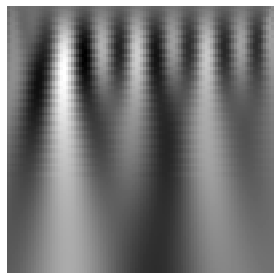

In [204]:
some_cwt = pd.DataFrame(cwt_data[1])
some_cwt_image = some_cwt.values.reshape(100, 100)
plt.imshow(some_cwt_image, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")

save_fig("some_cwt_plot")
plt.show()

In [209]:
channels_cwt = pd.DataFrame(
    {'Channel': cwt_labels,
     'CWT': cwt_data,
    })

cwt_groups = channels_cwt.groupby('Channel')

for name, group in cwt_groups:
    print(name)

1
2
3
4
5
6
7
8
